**Forecasting Fraudulent Transaction Volumes: Time Series Analysis Using a GARCH(1,1) Model**

In [5]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt  
import plotly.express as px 

from sklearn.metrics import mean_absolute_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from arch import arch_model

**Partt 1: Prepare Data**

**Importing Data**

In [6]:
def wrangle(filepath):
    #Read data into csv
    df = pd.read_csv(filepath)
    
    # Combine 'Year' and 'Month' into a 'Date' column
    df['Date'] = df['Month'] + ' ' + df["Year \xa0 \xa0 \xa0"].astype(str)

    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%B %Y')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    # Sort the DataFrame by the new datetime index
    df.sort_index(inplace=True)

    # Keep only the 'Fraud Volumes (In Millions)' column
    fraud_series = df['Fraud Volumes (In Millions)']

    return fraud_series

In [7]:
fraud_series=wrangle(filepath="data/fraud_data.csv")
fraud_series.head()

Date
2009-07-01    4288.5786
2009-08-01    4365.7617
2009-09-01    4222.9797
2009-10-01    4366.1658
2009-11-01    3143.0898
Name: Fraud Volumes (In Millions), dtype: float64

**Part 2: Exploratory Analysis**

**Line plot**

- Showing the trend of fraud volumes over time.

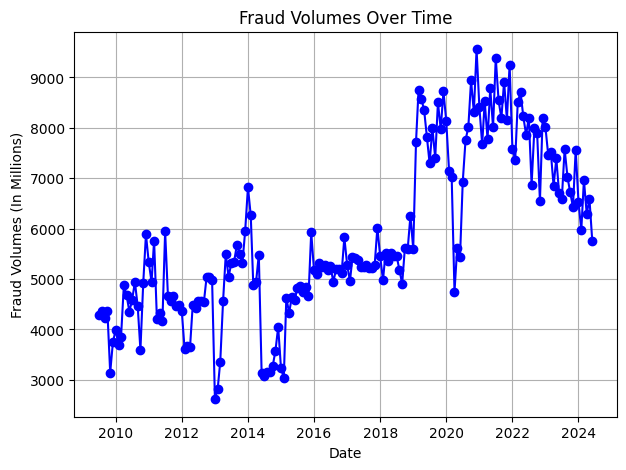

In [8]:
plt.figure(figsize=(7, 5))
plt.plot(fraud_series, marker='o', linestyle='-', color='b')
plt.title('Fraud Volumes Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Volumes (In Millions)')
plt.grid(True)
plt.show()

**Rolling Mean**

- Showing original fraud volumes alongside the rolling mean (moving average) - for smoothing out short-term fluctuations and highliting long-term trends

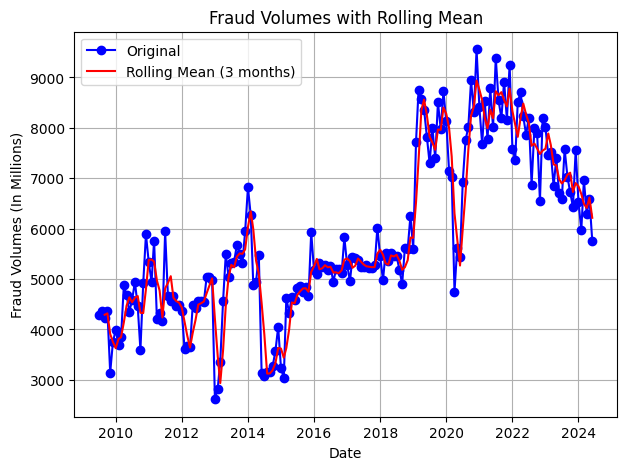

In [9]:
# Rolling mean with a window of 3 periods
rolling_mean = fraud_series.rolling(window=3).mean()

plt.figure(figsize=(7, 5))
plt.plot(fraud_series, marker='o', linestyle='-', color='b', label='Original')
plt.plot(rolling_mean, color='r', label='Rolling Mean (3 months)')
plt.title('Fraud Volumes with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Fraud Volumes (In Millions)')
plt.legend()
plt.grid(True)
plt.show()


- Plot of rolling mean and variance can visually indicate whether a series is stationary. 

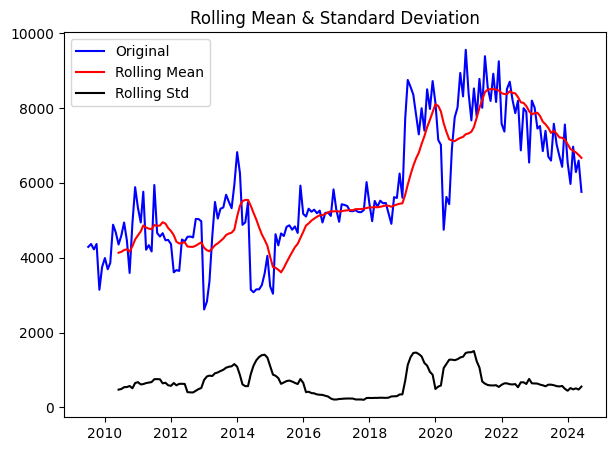

In [10]:
rolling_mean = fraud_series.rolling(window=12).mean()
rolling_std = fraud_series.rolling(window=12).std()

plt.figure(figsize=(7, 5))
plt.plot(fraud_series, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

**Histogram of Fraud Volumes**

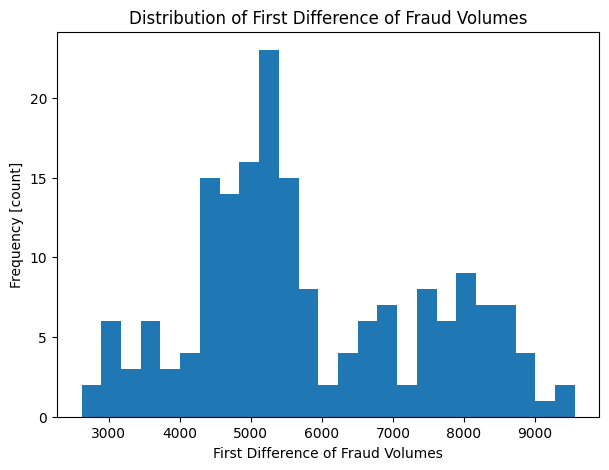

In [11]:
plt.figure(figsize=(7, 5))
plt.hist(fraud_series, bins=25)

# Add axis labels
plt.xlabel("First Difference of Fraud Volumes")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of First Difference of Fraud Volumes")

plt.show();

- From the above plot, it turns out that volume of transaction frauds follows a non-normal distribution. 

**Seasonal Decomposition Plot**

- Showing the correlation between fraud volume and its own lagged values - for identifying seasonality and the persistence of trends.

- Seasonality is the patterns or fluctuations in the volume of fraud over time. 
- We say seasonality when these patterns are tied to specific periods such as months or years.
- For example, the graphs below shows seasonality in the fraud volumes. 

<Figure size 700x500 with 0 Axes>

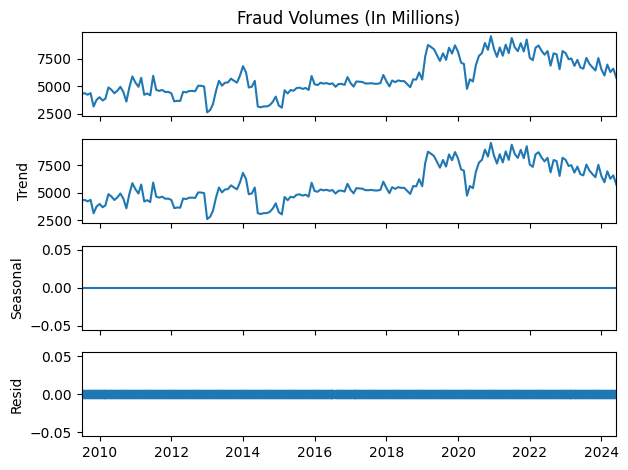

In [12]:
# Decomposing the time series using an additive model
plt.figure(figsize=(7, 5))
decomposition = seasonal_decompose(fraud_series, model='additive', period=1)
decomposition.plot()
plt.show()


**Part 3: Diagnostic Tests: Stationarity**

- A series with seasonality is not often stationary since the patterns induce regualr fluctuations in the mean (and possibly variance).
- Since fraud volume displays seasonality, it is in order to conduct a formal test to confirm stationarity before modelling. 

In [13]:
adf_result = adfuller(fraud_series)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')


ADF Statistic: -1.2238678992141985
p-value: 0.6632450057782564
Critical Values:
   1%, -3.470616369591229
Critical Values:
   5%, -2.8792214018977655
Critical Values:
   10%, -2.57619681359045


**Null Hypothesis** - The series has a unit root or not-stationary. 

**ADF Statistic Vs Critical Values**
- The ADF statistic is greater than the critcal values ar 1%, 5%, and 10% significance levels.
- The ADF statitic does not fall within the rejection region.


**p-Value**
- The p-value is also higher than all the three levels of significance.
- Therefore, we fail to reject the null hypothessis. 

**Conclusion** - Not eneough evidence to conclude that the volume of fraud is stationary. The series is likely to have a unit root, and may be stationary. 

**Non-stationarity to stationarity**

**Method 1: Logarithmic Transformation**

In [14]:
log_frauds = np.log(fraud_series)
log_frauds

Date
2009-07-01    8.363711
2009-08-01    8.381548
2009-09-01    8.348296
2009-10-01    8.381641
2009-11-01    8.052962
                ...   
2024-02-01    8.694825
2024-03-01    8.849146
2024-04-01    8.746602
2024-05-01    8.794074
2024-06-01    8.658793
Name: Fraud Volumes (In Millions), Length: 180, dtype: float64

**ADF Test**

In [15]:
adf_result = adfuller(log_frauds)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')


ADF Statistic: -1.2786007358807037
p-value: 0.6389047598311984
Critical Values:
   1%, -3.470616369591229
Critical Values:
   5%, -2.8792214018977655
Critical Values:
   10%, -2.57619681359045


- From the ADF test, **logarithmic transformation does not make the series stationary**. 

**Method 2: Differencing**

In [16]:
fraud_diff = fraud_series.diff().dropna()

In [17]:
adf_result = adfuller(fraud_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.1523815654561425
p-value: 1.0989105479053515e-05
Critical Values:
   1%, -3.470616369591229
Critical Values:
   5%, -2.8792214018977655
Critical Values:
   10%, -2.57619681359045


- From the ADF, **taking the first difference makes the series stationary.**
- Therefore, we will use the first difference for analysis. 

**Part 3: Exploratory Analysis of the first difference of the series**

**1. Line Plot**

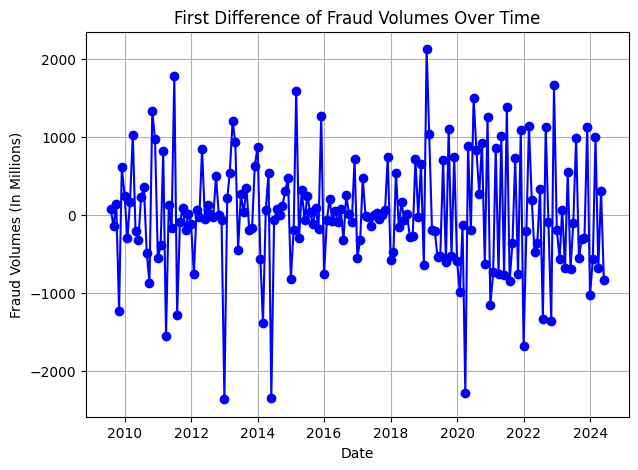

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(fraud_diff, marker='o', linestyle='-', color='b')
plt.title('First Difference of Fraud Volumes Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Volumes (In Millions)')
plt.grid(True)
plt.show()

**2. Histogram**

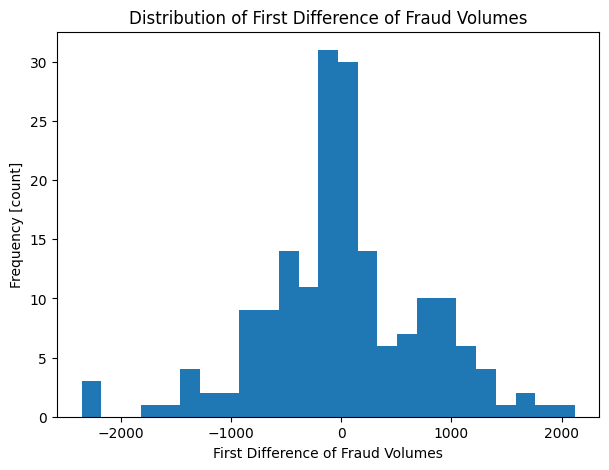

In [19]:
plt.figure(figsize=(7, 5))
plt.hist(fraud_diff, bins=25)

# Add axis labels
plt.xlabel("First Difference of Fraud Volumes")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of First Difference of Fraud Volumes")

plt.show();

- From the above plot, tt turns out that first difference follows an almost normal distribution, centered on 0. 

**3. Seasonal Decomposition**

<Figure size 700x500 with 0 Axes>

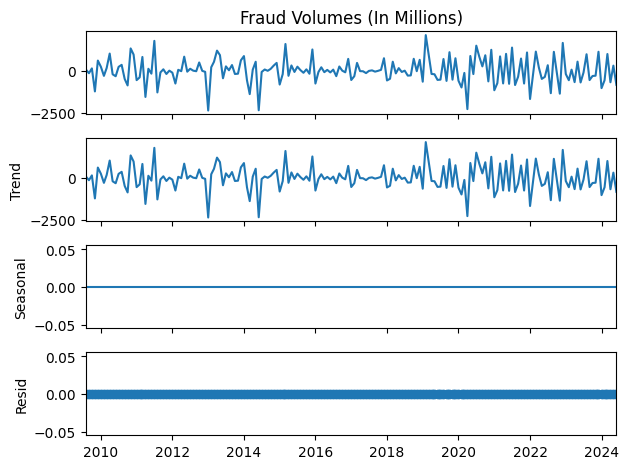

In [20]:
# Decomposing the time series using an additive model
plt.figure(figsize=(7, 5))
decomposition = seasonal_decompose(fraud_diff, model='additive', period=1)
decomposition.plot()
plt.show()

**4. Rolling Standard Deviation**

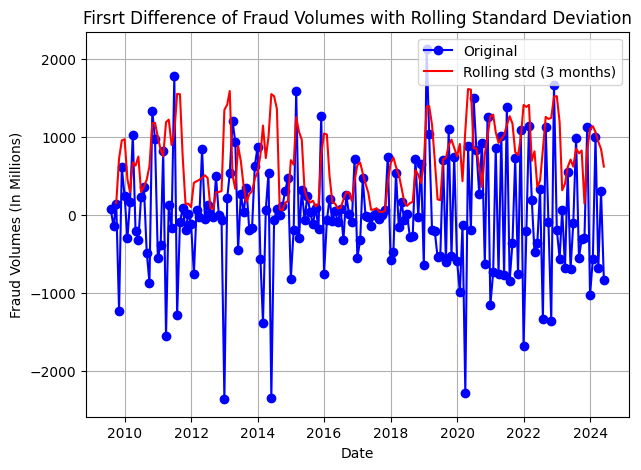

In [21]:
# Rolling Deviation with a window of 3 periods
rolling_mean = fraud_diff.rolling(window=3).std()

plt.figure(figsize=(7, 5))
plt.plot(fraud_diff, marker='o', linestyle='-', color='b', label='Original')
plt.plot(rolling_mean, color='r', label='Rolling std (3 months)')
plt.title('Firsrt Difference of Fraud Volumes with Rolling Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Fraud Volumes (In Millions)')
plt.legend()
plt.grid(True)
plt.show()

- We can see that the standard deviation goes up when the first difference of the fraud volumes change drastically — either up or down. For instance, we can see a big increase between 2014 and 2015, when there were several months of large negative differences.

- We can also see the standard deviation go down in 2025, when there are only small day-to-day changes in returns.

- The idea is to use the first difference values to see if high standard deviation on a particular month is assicatiated with high standard deviation on the following month - the probelm

- However, high standard deviations is caused by large changes in the first difference of the fraud volumes, which can be either positive or negative.

- How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error

- The other solution, which is more common in this context, is to square all the values.

**Plot of Squared First Differences**

<Figure size 700x500 with 0 Axes>

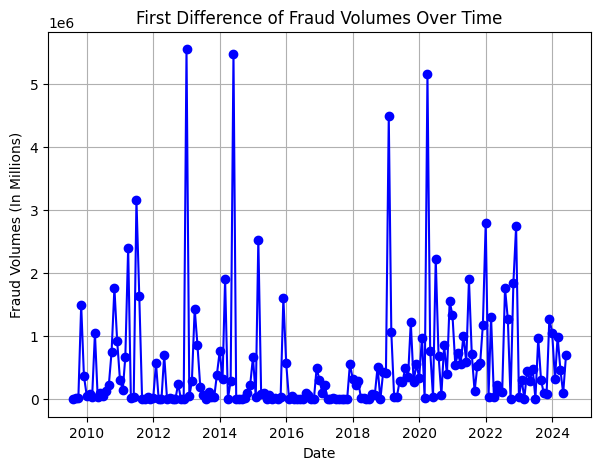

In [22]:
plt.figure(figsize=(7, 5))
diff_squared = fraud_diff**2
plt.figure(figsize=(7, 5))
plt.plot(diff_squared , marker='o', linestyle='-', color='b')
plt.title('First Difference of Fraud Volumes Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Volumes (In Millions)')
plt.grid(True)
plt.show()

- From the above plot, periods of high and low differences, and high difference months tend to cluster together. 
- This is a perfect situation to use a GARCH model.

**ACF of Squared Differences**

<Figure size 700x500 with 0 Axes>

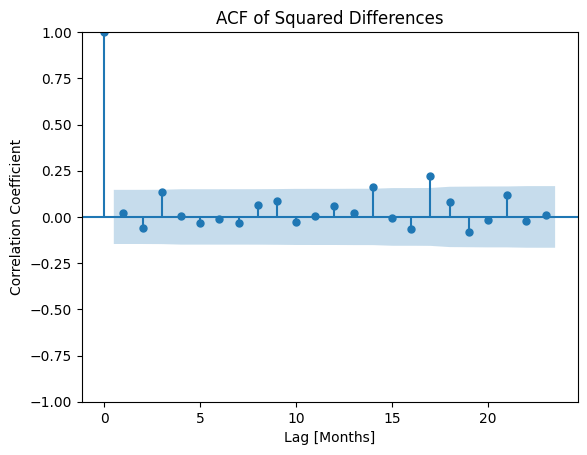

In [23]:
plt.figure(figsize=(7, 5))
plot_acf(diff_squared)
plt.title('ACF of Squared Differences')
plt.xlabel("Lag [Months]")
plt.ylabel("Correlation Coefficient");
plt.show()

**PACF of Squared Differences**

<Figure size 700x500 with 0 Axes>

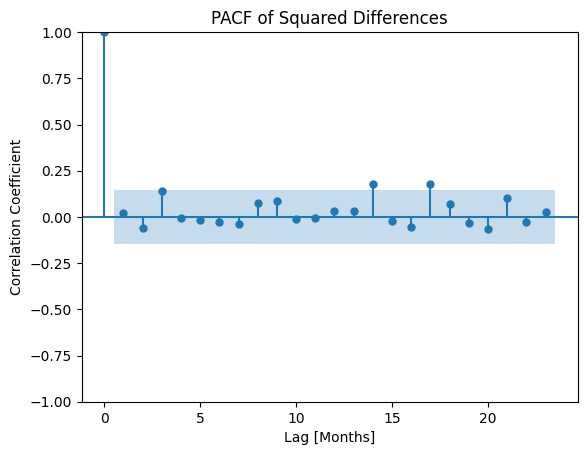

In [24]:
plt.figure(figsize=(7, 5))
plot_pacf(diff_squared)
plt.title('PACF of Squared Differences')
plt.xlabel("Lag [Months]")
plt.ylabel("Correlation Coefficient");
plt.show()

- From the AFC and PACF plots, the autocorrelation coefficient becomes significantly different from zero at lag 1. This means that the optimal lag for the GARCH model is 1.
- This indicates that the squared differences at time t are significantly correlated with the squared differences at time t-1, suggesting that a GARCH(1,1) model would be appropriate for this time series data.

**Split Data: Training, Testing and Validation Sets**

In [29]:
cutoff_test = int(len(fraud_diff) * .8)
train_set = fraud_diff.iloc[:cutoff_test]

print("train type:", type(train_set))
print("train shape:", train_set.shape)
train_set.tail()

train type: <class 'pandas.core.series.Series'>
train shape: (143,)


Date
2021-02-01    -733.5762
2021-03-01     853.8633
2021-04-01    -749.3361
2021-05-01    1005.2661
2021-06-01    -771.9657
Name: Fraud Volumes (In Millions), dtype: float64

**Part 4: Build Model**

In [30]:
# Build and train model
model = arch_model(
    train_set ,
    p=1,
    q=1,
    rescale=False).fit(0)
print("model type:", type(model))

# Show model summary
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1141.261884137698
            Iterations: 17
            Function evaluations: 91
            Gradient evaluations: 17
model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Constant Mean - GARCH Model Results                          
=======================================================================================
Dep. Variable:     Fraud Volumes (In Millions)   R-squared:                       0.000
Mean Model:                      Constant Mean   Adj. R-squared:                  0.000
Vol Model:                               GARCH   Log-Likelihood:               -1141.26
Distribution:                           Normal   AIC:                           2290.52
Method:                     Maximum Likelihood   BIC:                           2302.38
                                                 No. Observations:                  143
Date:                         Wed, Sep 04 2024   Df Residuals:                      142
Time:                                 21:13:10   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            22.3699     57.098      0.392      0.695 [-89.540,1.343e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.0492e+04  7.042e+04      0.717      0.473 [-8.752e+04,1.885e+05]
alpha[1]       0.0340  5.524e-02      0.616      0.538   [-7.422e-02,  0.142]
beta[1]        0.8701      0.113      7.715  1.207e-14      [  0.649,  1.091]
=============================================================================

Covariance estimator: robust
"""

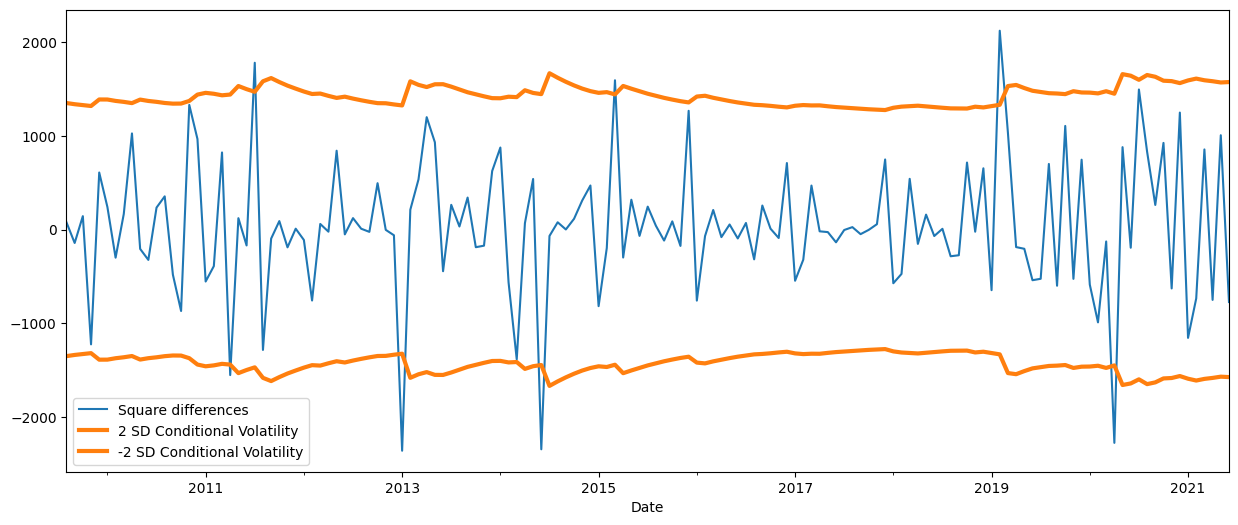

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot train_set 
train_set .plot(ax=ax, label="Square differences")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax,
    color="C1",
    label="2 SD Conditional Volatility",
    linewidth=3 
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename()).plot(
    ax=ax,
    color="C1",
    label="-2 SD Conditional Volatility",
    linewidth=3 
)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();